In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import re
from pprint import pprint

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

from collections import Counter
from wordcloud import WordCloud


import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aquil\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_pickle('df_islam.pkl')

In [3]:
df.shape

(4895, 5)

In [4]:
df

,tweet_text,tidy_tweet,tidy_tweet_tokens,tokens_no_stop,no_stop_joined
0,Islam is a religion full of blessings and good...,islam full blessings good deeds which also res...,"[islam, full, blessings, good, deeds, which, a...","[islam, full, blessings, good, deeds, also, re...",islam full blessings good deeds also respected...
11,@ haaretzcom @ RahimGulIB When a Muslim does s...,when muslim does something islam fault when ch...,"[when, muslim, does, something, islam, fault, ...","[muslim, something, islam, fault, christian, s...",muslim something islam fault christian somethi...
18,We're supposed to respect the religion of Isla...,supposed respect islam where hugging kissing a...,"[supposed, respect, islam, where, hugging, kis...","[supposed, respect, islam, hugging, kissing, a...",supposed respect islam hugging kissing alcohol...
26,@ GulfWarVet123 @ presidentdiary and ur kids/g...,kids grandkids friends relatives them they don...,"[kids, grandkids, friends, relatives, them, th...","[kids, grandkids, friends, relatives, dont, be...",kids grandkids friends relatives dont become i...
31,Islam is a Religion of Peace- Intelligence Squ...,islam peace intelligence squared,"[islam, peace, intelligence, squared]","[islam, peace, intelligence, squared]",islam peace intelligence squared
...,...,...,...,...,...
49414,Both Islam and secular people have shown their...,both islam secular people have shown their hat...,"[both, islam, secular, people, have, shown, th...","[islam, secular, people, shown, hate, attackin...",islam secular people shown hate attacking laws...
49421,Have u ever read islam if not then u r the big...,have ever read islam then biggest fool earth t...,"[have, ever, read, islam, then, biggest, fool,...","[ever, read, islam, biggest, fool, earth, read...",ever read islam biggest fool earth read islam ...
49425,Can you please make a public statement on your...,please make public statement your previous isl...,"[please, make, public, statement, your, previo...","[please, make, public, statement, previous, is...",please make public statement previous islamoph...
49436,"So, for example, the persecution of the Uyghur...",example persecution uyghurs really just under ...,"[example, persecution, uyghurs, really, just, ...","[example, persecution, uyghurs, really, mask, ...",example persecution uyghurs really mask functi...


In [5]:
df = df.drop(['tidy_tweet','tidy_tweet_tokens','no_stop_joined'], axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4895 entries, 0 to 49447
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_text      4895 non-null   object
 1   tokens_no_stop  4895 non-null   object
dtypes: object(2)
memory usage: 114.7+ KB


In [7]:
df.head()

,tweet_text,tokens_no_stop
0,Islam is a religion full of blessings and good...,"[islam, full, blessings, good, deeds, also, re..."
11,@ haaretzcom @ RahimGulIB When a Muslim does s...,"[muslim, something, islam, fault, christian, s..."
18,We're supposed to respect the religion of Isla...,"[supposed, respect, islam, hugging, kissing, a..."
26,@ GulfWarVet123 @ presidentdiary and ur kids/g...,"[kids, grandkids, friends, relatives, dont, be..."
31,Islam is a Religion of Peace- Intelligence Squ...,"[islam, peace, intelligence, squared]"


In [8]:
def remove_links(tweet):
    tweet_no_link = re.sub(r"http\S+", "", tweet)
    return tweet_no_link

In [9]:
df['tweet_text_p'] = np.vectorize(remove_links)(df['tweet_text'])

In [10]:
def remove_links(tweet):
    tweet_no_link = re.sub(r"twitter.com\S+", "", tweet)
    return tweet_no_link

In [11]:
df['tweet_text_p'] = np.vectorize(remove_links)(df['tweet_text_p'])

In [12]:
def remove_users(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

In [13]:
df['tweet_text_p'] = np.vectorize(remove_users)(df['tweet_text_p'], "@ [\w]*", "@[\w]*")

In [14]:
# We decided to keep hashtags because they add value to the sentiment.
# Example df.tweet_text[20]
def remove_hashtags(tweet, pattern1):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

In [15]:
df['tweet_text_p'] = np.vectorize(remove_hashtags)(df['tweet_text_p'], "#")

In [16]:
# It adds to the neutrality of the tweet as the compound score is the sum of all words sentiment score. 
# Example df.tweet_text[43]
def remove_word(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, "", tweet)
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

In [17]:
df['tweet_text_p'] = np.vectorize(remove_word)(df['tweet_text_p'], "religion", "Religion")

In [18]:
# Removing Punctuation has no significant impact in most cases 
# In some cases reduces the neutrality because of words in parentheses
# Example df.tweet_text[50]
# df['pre_processed_1'] = df['pre_processed'].str.replace("[^a-zA-Z#]", " ")

In [19]:
df.drop_duplicates(subset=['tweet_text_p'], keep='first', inplace=True)

In [20]:
df = df[~df.tweet_text_p.str.contains("Retweeted")]

In [21]:
df.shape

(4781, 3)

In [22]:
# Create an object of Vader Sentiment Analyzer
vader_analyzer = SentimentIntensityAnalyzer()

In [23]:
negative = []
neutral = []
positive = []
compound = []

In [24]:
def sentiment_scores(df, negative, neutral, positive, compound):
    for i in df['tweet_text_p']:
        sentiment_dict = vader_analyzer.polarity_scores(i)
        negative.append(sentiment_dict['neg'])
        neutral.append(sentiment_dict['neu'])
        positive.append(sentiment_dict['pos'])
        compound.append(sentiment_dict['compound'])

In [25]:
# Function calling 
sentiment_scores(df, negative, neutral, positive, compound)

In [26]:
# Prepare columns to add the scores later
df["negative"] = negative
df["neutral"] = neutral
df["positive"] = positive
df["compound"] = compound

In [27]:
# Fill the overall sentiment with encoding:
# (-1)Negative, (0)Neutral, (1)Positive
sentiment = []
for i in df['compound']:
    if i >= 0.05 : 
        sentiment.append(1)
  
    elif i <= - 0.05 : 
        sentiment.append(-1) 
        
    else : 
        sentiment.append(0)
df['sentiment'] = sentiment

In [28]:
neg_tweets = df.sentiment.value_counts()[-1]
neu_tweets = df.sentiment.value_counts()[0]
pos_tweets = df.sentiment.value_counts()[1]

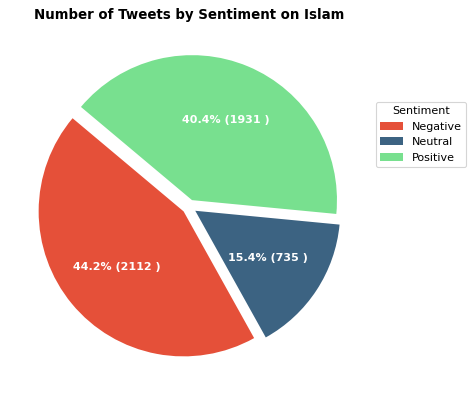

In [29]:
# Draw Plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"), dpi= 80)

data = [df.sentiment.value_counts()[-1], df.sentiment.value_counts()[0], df.sentiment.value_counts()[1]]
categories = ['Negative', 'Neutral', 'Positive']
explode = [0.05,0.05,0.05]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=['#e55039', '#3c6382', '#78e08f'],
                                  startangle=140,
                                  explode=explode)

# Decoration
ax.legend(wedges, categories, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0.2, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Number of Tweets by Sentiment on Islam", fontsize=12, fontweight="bold")
plt.show()

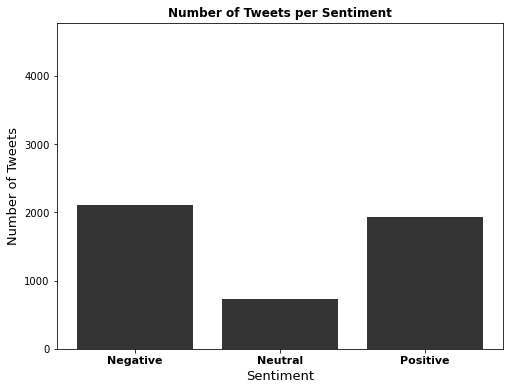

In [30]:
labels = ['Negative', 'Neutral', 'Positive']
freq = [df.sentiment.value_counts()[-1], df.sentiment.value_counts()[0], df.sentiment.value_counts()[1]]
index = np.arange(len(freq))

plt.figure(figsize=(8,6))
plt.bar(index, freq, alpha=0.8, color= 'black')
plt.xlabel('Sentiment', fontsize=13)
plt.ylabel('Number of Tweets', fontsize=13)
plt.xticks(index, labels, fontsize=11, fontweight="bold") 
plt.title('Number of Tweets per Sentiment', fontsize=12, fontweight="bold")
plt.ylim(0, len(df['tweet_text']))
plt.show()

In [31]:
# We remove the neutral compound scores to compare the negative and positive tweets
data = df[(df["sentiment"]!=0)]

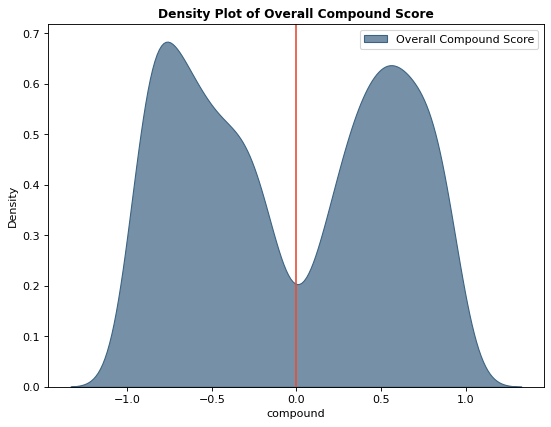

In [32]:
# Draw Plot
plt.figure(figsize=(8,6), dpi= 80)
sns.kdeplot(data["compound"], shade=True, color="#3c6382", label="Overall Compound Score", alpha=.7)

# Decoration
plt.title('Density Plot of Overall Compound Score', fontsize=11, fontweight='bold')
plt.axvline(x=0, color='#e55039')
plt.legend()
plt.show()

In [33]:
def lemmatization(tweets, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    tweets_out = []
    for sent in tweets:
        doc = nlp(" ".join(sent)) 
        tweets_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return tweets_out

In [34]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [35]:
# Do lemmatization keeping only noun, adj, vb, adv
df['lemmatized'] = lemmatization(df['tokens_no_stop'], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [36]:
df.drop(['tokens_no_stop'], axis=1, inplace=True)

In [37]:
df_pos = df[df['sentiment']==1]
df_neg = df[df['sentiment']==(-1)]

In [38]:
# Join the tweet back together
def rejoin_words(row):
    words = row['lemmatized']
    joined_words = (" ".join(words))
    return joined_words

In [39]:
df_neg['no_stop_joined'] = df_neg.apply(rejoin_words, axis=1)

<ipython-input-39-e8ab93851a52>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['no_stop_joined'] = df_neg.apply(rejoin_words, axis=1)


In [40]:
word_freq = pd.Series(np.concatenate([x.split() for x in df_neg.no_stop_joined])).value_counts()

In [41]:
word_df = pd.Series.to_frame(word_freq)
word_df['word'] = list(word_df.index)
word_df.reset_index(drop=True, inplace=True)
word_df.columns = ['freq', 'word']

In [42]:
word_df.drop([ 0, 1], inplace=True)

Unique words: 3776


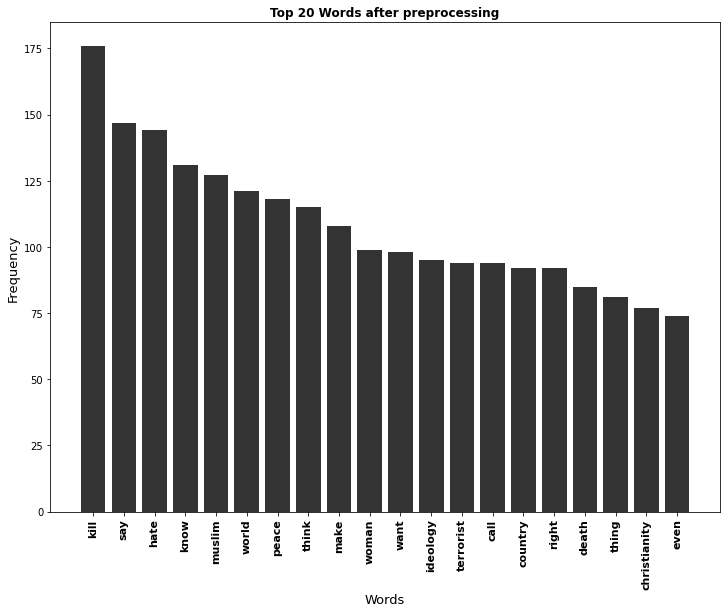

In [43]:
label = word_df['word'].head(20)
freq = word_df['freq'].head(20)
index = np.arange(len(freq))

print("Unique words:", len(word_df))
plt.figure(figsize=(12,9))
plt.bar(index, freq, alpha=0.8, color= 'black')
plt.xlabel('Words', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(index, label, fontsize=11, rotation=90, fontweight="bold") 
plt.title('Top 20 Words after preprocessing', fontsize=12, fontweight="bold")
plt.show()

In [44]:
# Join the tweet back together
def rejoin_words(row):
    words = row['lemmatized']
    joined_words = (" ".join(words))
    return joined_words

In [45]:
df_pos['no_stop_joined'] = df_pos.apply(rejoin_words, axis=1)

<ipython-input-45-96cf09404e60>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos['no_stop_joined'] = df_pos.apply(rejoin_words, axis=1)


In [46]:
word_freq_pos = pd.Series(np.concatenate([x.split() for x in df_pos.no_stop_joined])).value_counts()

In [47]:
word_df_pos = pd.Series.to_frame(word_freq_pos)
word_df_pos['word'] = list(word_df_pos.index)
word_df_pos.reset_index(drop=True, inplace=True)
word_df_pos.columns = ['freq', 'word']

In [48]:
word_df_pos.drop([0,2], inplace=True)

Unique words: 3294


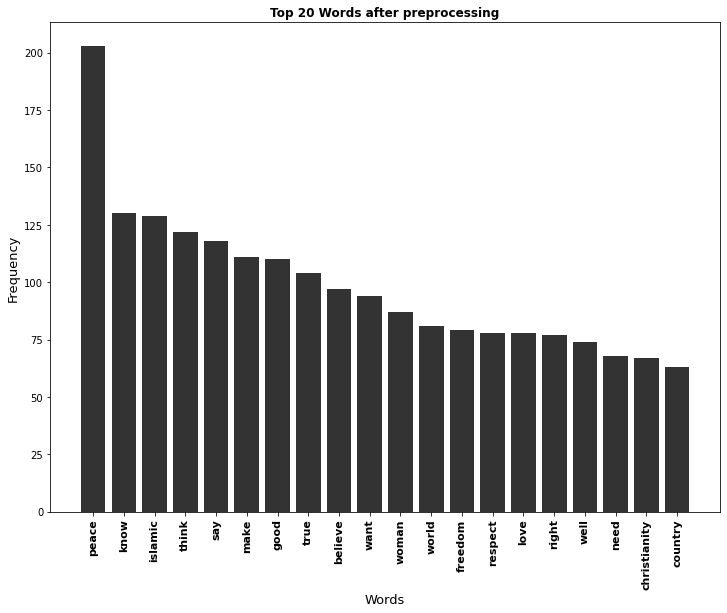

In [49]:
label = word_df_pos['word'].head(20)
freq = word_df_pos['freq'].head(20)
index = np.arange(len(freq))

print("Unique words:", len(word_df_pos))
plt.figure(figsize=(12,9))
plt.bar(index, freq, alpha=0.8, color= 'black')
plt.xlabel('Words', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(index, label, fontsize=11, rotation=90, fontweight="bold") 
plt.title('Top 20 Words after preprocessing', fontsize=12, fontweight="bold")
plt.show()

In [50]:
word_df_pos.head(20)

,freq,word
1,203,peace
3,130,know
4,129,islamic
5,122,think
6,118,say
7,111,make
8,110,good
9,104,true
10,97,believe
11,94,want


In [51]:
word_df.head(20)

,freq,word
2,176,kill
3,147,say
4,144,hate
5,131,know
6,127,muslim
7,121,world
8,118,peace
9,115,think
10,108,make
11,99,woman


In [52]:
# Join the tweet back together
def rejoin_words(row):
    words = row['lemmatized']
    joined_words = (" ".join(words))
    return joined_words

In [53]:
all_words_pos = ' '.join([text for text in df_pos.apply(rejoin_words, axis=1)])
all_words_neg = ' '.join([text for text in df_neg.apply(rejoin_words, axis=1)])

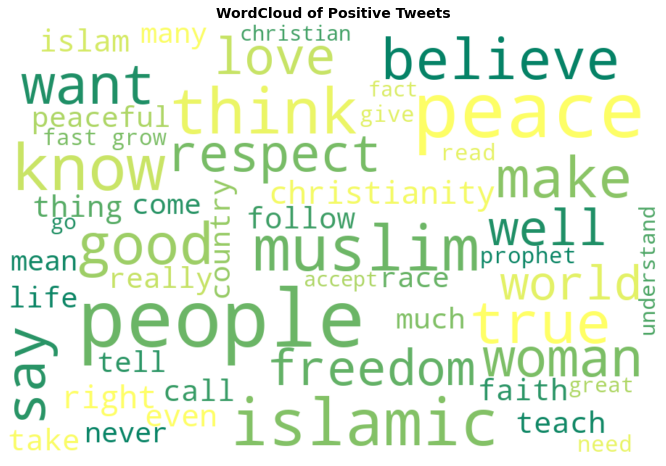

In [54]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='white', 
                      max_words=50,colormap='summer').generate(all_words_pos)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Positive Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

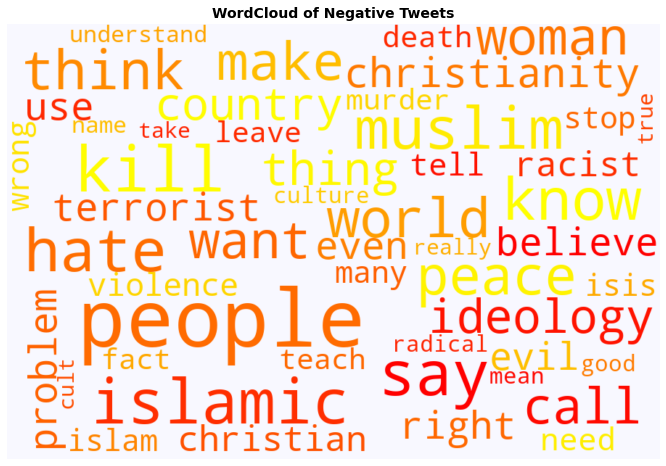

In [55]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='ghostwhite', 
                      max_words=50,colormap='autumn').generate(all_words_neg)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Negative Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Compound Score Distribution 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


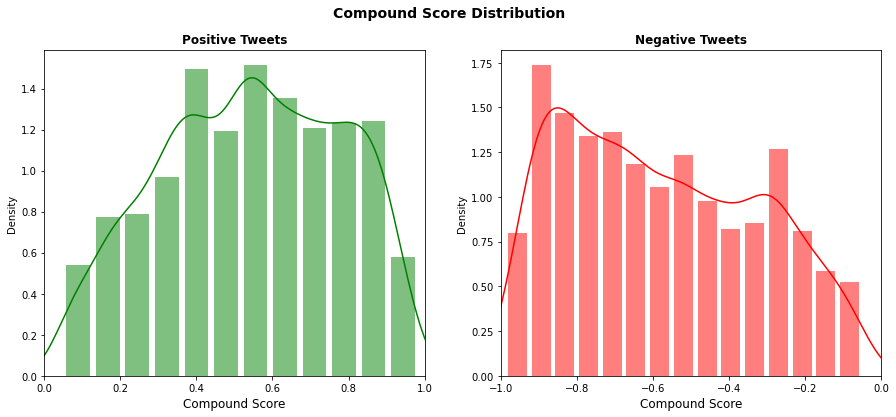

In [56]:
x1 = df_pos['compound']
x2 = df_neg['compound']
plt.figure(figsize=(15,6))
plt.suptitle('Compound Score Distribution', fontsize=14, fontweight="bold")
plt.subplot(1,2,1)

sns.distplot(x1, color="g", bins=12, hist_kws={"alpha": 0.5,"rwidth":0.8})
plt.title('Positive Tweets',fontsize=12, fontweight="bold")
plt.xlabel("Compound Score", fontsize=12)
plt.xlim([0,1])

# Chart 2: Derivative Function
plt.subplot(1,2,2)
sns.distplot(x2, color="r", bins=15, hist_kws={"alpha": 0.5, "rwidth":0.8})
plt.title("Negative Tweets",fontsize=12, fontweight="bold")
plt.xlabel("Compound Score", fontsize=12)
plt.xlim([-1,0])

plt.show()

In [57]:
x1.describe()

count    1932.000000
mean        0.541582
std         0.234494
min         0.050700
25%         0.361200
50%         0.542300
75%         0.735100
max         0.981700
Name: compound, dtype: float64

In [58]:
x2.describe()

count    2113.000000
mean       -0.578285
std         0.252902
min        -0.987800
25%        -0.799900
50%        -0.612400
75%        -0.361200
max        -0.051600
Name: compound, dtype: float64

In [59]:
# 10 Most positive Tweets
df_pos.sort_values('compound', inplace=True, ascending=False)
df_pos.reset_index(drop=True, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [60]:
df_pos.head(10)

,tweet_text,tweet_text_p,negative,neutral,positive,compound,sentiment,lemmatized,no_stop_joined
0,Whn I was trying to focus more on DEEN someone...,Whn I was trying to focus more on DEEN someone...,0.000,0.618,0.382,0.9817,1,"[try, focus, deen, tell, soon, feel, routine, ...",try focus deen tell soon feel routine alhamdul...
1,# Islam is a beautiful # religion. It teaches ...,"Islam is a beautiful . It teaches patience,...",0.000,0.528,0.472,0.9792,1,"[beautiful, teach, love, importance, seek, kno...",beautiful teach love importance seek knowledge...
2,Pronouncements in a religion does play its par...,"Pronouncements in a does play its part but, i...",0.000,0.631,0.369,0.9771,1,"[pronouncement, play, part, take, partner, mak...",pronouncement play part take partner make work...
3,FREEDOM TO CHOOSE RELIGION IS A HUMAN RIGHT!! ...,FREEDOM TO CHOOSE RELIGION IS A HUMAN RIGHT!! ...,0.023,0.547,0.430,0.9738,1,"[freedom, choose, human, right, freedom, wear,...",freedom choose human right freedom wear want w...
4,"ADNAN OKTAR: For one thing, Islam is a religio...","ADNAN OKTAR: For one thing, Islam is a of pea...",0.000,0.312,0.688,0.9686,1,"[adnan, oktar, thing, affection, compassion, f...",adnan oktar thing affection compassion friends...
5,Islam is completely intolerant? Lmao a religio...,Islam is completely intolerant? Lmao a that r...,0.000,0.328,0.672,0.9663,1,"[completely, intolerant, reward, smile, good, ...",completely intolerant reward smile good thought
6,allegation against Islam is that it is a relig...,allegation against Islam is that it is a that...,0.000,0.662,0.338,0.9656,1,"[oppress, woman, prophet, mohammad, also, attr...",oppress woman prophet mohammad also attribute ...
7,"thats true, iran is a great country and deserv...","thats true, iran is a great country and deserv...",0.000,0.621,0.379,0.9639,1,"[s, true, great, country, deserve, glory, isla...",s true great country deserve glory islam probl...
8,# WhatIKnowAboutIslam is that i am in love wit...,WhatIKnowAboutIslam is that i am in love with...,0.000,0.503,0.497,0.9628,1,"[love, study, peace, harmony]",love study peace harmony
9,In every religion there is love e.g. be it Hin...,In every there is love e.g. be it Hinduisam o...,0.026,0.608,0.365,0.9618,1,"[love, culture, boundary, race, love, pure, be...",love culture boundary race love pure beautiful...


In [61]:
# 10 Most Negative Tweets
df_neg.sort_values('compound', inplace=True)
df_neg.reset_index(drop=True, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [62]:
df_neg.head(10)

,tweet_text,tweet_text_p,negative,neutral,positive,compound,sentiment,lemmatized,no_stop_joined
0,That's what they live for. The desalination of...,That's what they live for. The desalination of...,0.649,0.351,0.000,-0.9878,-1,"[live, desalination, other, hate, murder, rape...",live desalination other hate murder rape pure ...
1,Threatening murder against a poor woman is not...,Threatening murder against a poor woman is not...,0.500,0.466,0.034,-0.9873,-1,"[threaten, murder, poor, woman, protect, harm,...",threaten murder poor woman protect harm engage...
2,"Agreed, for all but Islam. It's a cult of war ...","Agreed, for all but Islam. It's a cult of war ...",0.525,0.448,0.027,-0.9871,-1,"[agree, death, call, confuse, public, beheadin...",agree death call confuse public beheading rape...
3,"Christ is dead too you know, but I hear y'all,...","Christ is dead too you know, but I hear y'all,...",0.452,0.478,0.070,-0.9867,-1,"[dead, know, hear, last, thing, need, bullshit...",dead know hear last thing need bullshit push e...
4,That is not what China is saying. China is say...,That is not what China is saying. China is say...,0.417,0.532,0.050,-0.9847,-1,"[say, say, anywhere, else, hate, enemy, enemy,...",say say anywhere else hate enemy enemy kiss fa...
5,This is exactly why we (USA) must declare Isla...,This is exactly why we (USA) must declare Isla...,0.427,0.533,0.040,-0.9781,-1,"[exactly, declare, country, ideology, make, ev...",exactly declare country ideology make evil evi...
6,"It’s OK to track potential Islamic terrorists,...","It’s OK to track potential Islamic terrorists,...",0.432,0.453,0.114,-0.9777,-1,"[track, potential, islamic, terrorist, stop, d...",track potential islamic terrorist stop domesti...
7,Murder is wrong in Islamic countries. Murder i...,Murder is wrong in Islamic countries. Murder i...,0.442,0.505,0.053,-0.9773,-1,"[murder, wrong, islamic, country, murder, wron...",murder wrong islamic country murder wrong chri...
8,"How is it a ""thing""? Why is it okay to critici...","How is it a ""thing""? Why is it okay to critici...",0.402,0.550,0.048,-0.9764,-1,"[thing, criticise, idea, come, expose, alot, i...",thing criticise idea come expose alot idea ins...
9,"Disagree all u want, but u are wrong. He is le...","Disagree all u want, but u are wrong. He is le...",0.624,0.346,0.031,-0.9758,-1,"[disagree, want, wrong, leader, deception, ant...",disagree want wrong leader deception anti death


In [63]:
df.drop(['tweet_text_p', 'lemmatized'], axis=1, inplace=True)

In [64]:
df.to_pickle('sentiment_analysis_vader_results.pkl')